# Business Problem

The Department of Transportation is seeking assistance in understanding passenger demand, businesses can determine where and when taxis are needed most. This information can be used to optimize taxi fleet size and deployment, which can help to reduce wait times and improve customer satisfaction. The objective is to analyze this dataset and provide actionable insights to enhance businesses and gain insights that can help them to improve their operations and to better serve their customers. 

This project aims to explore the setup and use of Hadoop and pySpark to work on such data and analyses.


# About the dataset (courtesy: Kaggle.com)

## Context

The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP).

## Content

Column Description

tpep_pickup_datetime : The date and time when the meter was engaged.

tpep_dropoff_datetime : The date and time when the meter was disengaged.

Passenger_count : The number of passengers in the vehicle.( This is a driver-entered value )

Trip_distance : The elapsed trip distance in miles reported by the taximeter.

PULocationID : TLC Taxi Zone in which the taximeter was engaged

DOLocationID :TLC Taxi Zone in which the taximeter was disengaged

Payment_type A numeric code signifying how the passenger paid for the trip.

---- 1= Credit card

---- 2= Cash

---- 3= No charge

---- 4= Dispute

---- 5= Unknown

---- 6= Voided trip

Fare_amount : The time-and-distance fare calculated by the meter.

Extra : Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges.

MTA_tax : $0.50 MTA tax that is automatically triggered based on the metered rate in use.

Improvement_surcharge : $0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being 
levied in 2015.

Tip_amount : Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.

Tolls_amount : Total amount of all tolls paid in trip.

Total_amount : The total amount charged to passengers. Does not include cash tips

# Hadoop cluster setup

I setup a cluster on my local machine.

After extracting the Hadoop and Spark files (corresponding to Hadoop version 3.5 due to availability of winutils for this version) on the local drive, following user variables were setup on Windows:

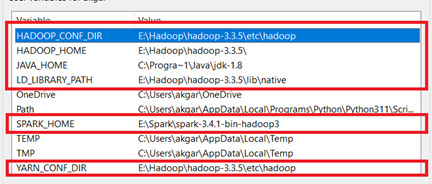

Below were the additions made to System path:

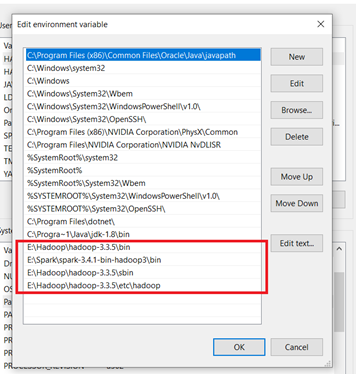

After updating the environment variables, below updates were made to the 4 Hadoop config files:

### Core-site.xml configuration:

    <configuration>
        <property>
            <name>fs.default.name</name>
            <value>hdfs://localhost:9820</value>
        </property>
    </configuration>

### hdfs-site.xml configuration:

    <configuration>
        <property>
            <name>dfs.replication</name>
            <value>1</value>
        </property>
        <property>
            <name>dfs.namenode.name.dir</name>
            <value>file:///E:/Hadoop/hadoop-3.3.5/data/dfs/namenode</value>
        </property>
        <property>
            <name>dfs.datanode.data.dir</name>
            <value>file:///E:/Hadoop/hadoop-3.3.5/data/dfs/datanode</value>
        </property>
    </configuration>

Namenode and datanode folders were created in the directory /data/dfs in the Hadoop installation folder.
Also, dfs.replication = 1 indicates single node cluster

### yarn-site.xml configuration:

    <configuration>

    <!-- Site specific YARN configuration properties -->
        <property>
            <name>yarn.nodemanager.aux-services</name>
            <value>mapreduce_shuffle</value>
            <description>Yarn Node Manager Aux Service</description>
        </property>

    </configuration>

### mapred-site.xml configuration:

    <configuration>
        <property>
            <name>mapreduce.framework.name</name>
            <value>yarn</value>
            <description>MapReduce framework name</description>
        </property>
    </configuration>

After starting the namenode, datanode, and yarn resource managers, a directory “/assignment2” was created using hdfs dfs -mkdir command.

Then, below command was used to load the dataset to HDFS:

hdfs dfs -put “E:\Mtech\DSE April 2022 batch\S3\Big Data\Assignment 2 data files\yellow_tripdata_2020-06.csv” “/assignment2”

Output of -ls:

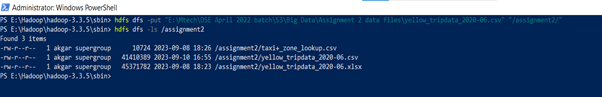

# Spark installation

After unpacking the Spark files, following updates were made to the config file. The spark.master property when set to “yarn” makes use of Hadoop Yarn as the job scheduler.

Spark-defaults.conf configuration:

      spark.master                      yarn
      spark.eventLog.enabled            true
      spark.eventLog.dir                hdfs:///spark-logs
      #spark.serializer                org.apache.spark.serializer.KryoSerializer
      #spark.driver.memory             5g
      #spark.executor.extraJavaOptions  -XX:+PrintGCDetails -Dkey=value -Dnumbers="one two    three"
      spark.history.provider            org.apache.spark.deploy.history.FsHistoryProvider
      spark.history.fs.logDirectory     hdfs:///spark-logs
      spark.history.fs.update.interval  10s
      spark.history.ui.port             18080
      spark.yarn.jars	                  hdfs:///spark/jars/*
      

Below is the python code for analysing the data using pySpark.



In [1]:
import pyspark
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("assignment2").getOrCreate()

In [3]:
df = spark.read.format("csv").option("header","true").option("inferSchema","true").load("hdfs:///assignment2/yellow_tripdata_2020-06.csv")

In [4]:
df.show()
df.describe()

+--------------------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------------------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|     01-06-2020 0.31|      01-06-2020 0.49|              1|          3.6|         140|          68|           1|       15.5|  3.0|    0.5|       4.0|         0.0|                  0.3|        23.3|
|     01-06-2020 0.42|      01-06-2020 1.04|              1|          5.6|          79|         226|           1|       19.5|  3.0|    0.5|       2.0|         0.0|                  0.3|        25.3|
|    

DataFrame[summary: string, tpep_pickup_datetime: string, tpep_dropoff_datetime: string, passenger_count: string, trip_distance: string, PULocationID: string, DOLocationID: string, payment_type: string, fare_amount: string, extra: string, mta_tax: string, tip_amount: string, tolls_amount: string, improvement_surcharge: string, total_amount: string]

In [5]:
#converting columns into required datatypes and creating new columns for hours
from pyspark.sql.functions import *
df = df.withColumn("tpep_dropoff_datetime",to_timestamp("tpep_dropoff_datetime","dd-MM-yyyy H.mm")).withColumn("tpep_pickup_datetime",to_timestamp("tpep_pickup_datetime","dd-MM-yyyy H.mm"))
df = df.withColumn("pickup_hour",hour(col("tpep_pickup_datetime"))).withColumn("drop_hour",hour(col("tpep_dropoff_datetime")))
df.show()

+--------------------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-----------+---------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|pickup_hour|drop_hour|
+--------------------+---------------------+---------------+-------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-----------+---------+
| 2020-06-01 00:31:00|  2020-06-01 00:49:00|              1|          3.6|         140|          68|           1|       15.5|  3.0|    0.5|       4.0|         0.0|                  0.3|        23.3|          0|        0|
| 2020-06-01 00:42:00|  2020-06-01 01:04:00|              1|          5.6|          79|         226|           1|   

In [6]:
df.dtypes

[('tpep_pickup_datetime', 'timestamp'),
 ('tpep_dropoff_datetime', 'timestamp'),
 ('passenger_count', 'int'),
 ('trip_distance', 'double'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int'),
 ('payment_type', 'int'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('mta_tax', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('improvement_surcharge', 'double'),
 ('total_amount', 'double'),
 ('pickup_hour', 'int'),
 ('drop_hour', 'int')]

In [7]:
#checking count before dropping records

df.count()

549760

In [8]:
#cleaning the data, removing nulls
df = df.dropna()
df.count()

499043

In [9]:
#removing negative values
df = df.filter((df.fare_amount>=0)&(df.extra>=0)&(df.mta_tax>=0)&(df.tip_amount>=0)&(df.tolls_amount>=0)&(df.improvement_surcharge>=0)&(df.total_amount>=0))
df.count()

496536

In [10]:
#getting number of taxi trips by hour
taxi_trips_by_hour = df.groupBy("pickup_hour").agg(count("pickup_hour")).orderBy("pickup_hour")
taxi_trips_by_hour.show(taxi_trips_by_hour.count())

+-----------+------------------+
|pickup_hour|count(pickup_hour)|
+-----------+------------------+
|          0|              6042|
|          1|              3795|
|          2|              2348|
|          3|              1661|
|          4|              1732|
|          5|              4763|
|          6|             13515|
|          7|             18743|
|          8|             23140|
|          9|             26580|
|         10|             30092|
|         11|             33034|
|         12|             35671|
|         13|             36964|
|         14|             37969|
|         15|             38695|
|         16|             36316|
|         17|             36233|
|         18|             32473|
|         19|             24865|
|         20|             17190|
|         21|             13746|
|         22|             11801|
|         23|              9168|
+-----------+------------------+



In [11]:
#creating table/view from the loaded dataframe
df.createOrReplaceTempView("yellow_tripdata_table_view")

In [12]:
#2.2.1.	Average fare amount collected by hour of the day
spark.sql("select pickup_hour,count(pickup_hour), sum(fare_amount), (sum(fare_amount)/count(pickup_hour)) as average_fare_amount_per_hour from yellow_tripdata_table_view group by pickup_hour order by pickup_hour").show(24)

+-----------+------------------+------------------+----------------------------+
|pickup_hour|count(pickup_hour)|  sum(fare_amount)|average_fare_amount_per_hour|
+-----------+------------------+------------------+----------------------------+
|          0|              6042| 96659.88999999987|           15.99799569678912|
|          1|              3795| 61735.29000000005|          16.267533596837957|
|          2|              2348|37727.770000000055|          16.068045144804113|
|          3|              1661| 27619.73000000004|          16.628374473208932|
|          4|              1732| 32817.16000000009|           18.94755196304855|
|          5|              4763|          58976.19|          12.382152005038842|
|          6|             13515|136391.43999999994|           10.09185645578986|
|          7|             18743|199888.00999999954|          10.664675345462282|
|          8|             23140|242903.08999999956|          10.497108470181486|
|          9|             26

In [13]:
#2.2.2. Average fare amount compared to the average trip distance
spark.sql("select count(pickup_hour) as total_trips, sum(fare_amount) as total_fare_amt, sum(trip_distance) as total_trip_dist, (total_fare_amt/total_trips) as avg_fare_amt, (total_trip_dist/total_trips) as avg_trip_dist, (avg_fare_amt/avg_trip_dist) as avg_fare_per_mile from yellow_tripdata_table_view").show()

+-----------+-----------------+------------------+------------------+------------------+-----------------+
|total_trips|   total_fare_amt|   total_trip_dist|      avg_fare_amt|     avg_trip_dist|avg_fare_per_mile|
+-----------+-----------------+------------------+------------------+------------------+-----------------+
|     496536|5939425.320000261|1424608.3500000103|11.961721446179654|2.8690937817197755|4.169163630130496|
+-----------+-----------------+------------------+------------------+------------------+-----------------+



In [14]:
#2.2.3. Average fare amount and average trip distance by day of the week
spark.sql("select weekday(tpep_pickup_datetime) as day_of_the_week, sum(fare_amount)/count(fare_amount) as avg_fare_amt, sum(trip_distance)/count(trip_distance) as avg_trip_distance from yellow_tripdata_table_view group by day_of_the_week order by day_of_the_week").show(35)

+---------------+------------------+------------------+
|day_of_the_week|      avg_fare_amt| avg_trip_distance|
+---------------+------------------+------------------+
|              0|11.820456413365813|2.7616515090272142|
|              1|11.722335687479198| 2.678499259147114|
|              2|11.529796255899285|2.6460280593695233|
|              3|11.722720074587496| 2.731717597617636|
|              4|12.098342339520265|3.1077333124494113|
|              5|12.283156618685881|3.0808117292199757|
|              6| 13.20854166666677| 3.399258905852424|
+---------------+------------------+------------------+



In [15]:
#2.2.4 In the month of June 2020, find the zone which had maximum number of pick ups

#loading zones data from hdfs as a dataframe, then creating a table(view) of the same
df2 = spark.read.format("csv").option("header","true").option("inferSchema","true").load("hdfs:///assignment2/taxi+_zone_lookup.csv")
df2.createOrReplaceTempView("zones_table_view")

spark.sql("select Zone, count(tpep_pickup_datetime) as num_of_pickups from yellow_tripdata_table_view a left join zones_table_view b on a.PULocationID=b.LocationID where month(tpep_pickup_datetime)=6 and year(tpep_pickup_datetime)=2020 group by Zone order by num_of_pickups desc").show(1,truncate=0)

+---------------------+--------------+
|Zone                 |num_of_pickups|
+---------------------+--------------+
|Upper East Side North|22456         |
+---------------------+--------------+
only showing top 1 row



In [16]:
#2.2.5 In the month of June 2020, find the zone which had maximum number of drops
spark.sql("select Zone, count(tpep_dropoff_datetime) as num_of_drops from yellow_tripdata_table_view a left join zones_table_view b on a.DOLocationID=b.LocationID where month(tpep_dropoff_datetime)=6 and year(tpep_dropoff_datetime)=2020 group by Zone order by num_of_drops desc").show(1, truncate=0)

+---------------------+------------+
|Zone                 |num_of_drops|
+---------------------+------------+
|Upper East Side North|21658       |
+---------------------+------------+
only showing top 1 row



In [17]:
#2.2.6 Average no of passengers by hour of the day

spark.sql("select pickup_hour, count(passenger_count), sum(passenger_count), (sum(passenger_count)/count(passenger_count)) as avg_pgr_by_hr from yellow_tripdata_table_view group by pickup_hour order by pickup_hour").show(24)

+-----------+----------------------+--------------------+------------------+
|pickup_hour|count(passenger_count)|sum(passenger_count)|     avg_pgr_by_hr|
+-----------+----------------------+--------------------+------------------+
|          0|                  6042|                8042|  1.33101621979477|
|          1|                  3795|                4923|1.2972332015810277|
|          2|                  2348|                3075| 1.309625212947189|
|          3|                  1661|                2174| 1.308850090307044|
|          4|                  1732|                2230|1.2875288683602772|
|          5|                  4763|                6537|1.3724543355028342|
|          6|                 13515|               17986| 1.330817610062893|
|          7|                 18743|               25183|1.3435949421117217|
|          8|                 23140|               31464| 1.359723422644771|
|          9|                 26580|               35946| 1.352370203160271|

In [18]:
#2.2.7 Total number of payments made by different type for the month

spark.sql("select month(tpep_pickup_datetime) as month, payment_type, count(payment_type) as total_no_of_payments from yellow_tripdata_table_view group by month,payment_type order by month,payment_type").show()


+-----+------------+--------------------+
|month|payment_type|total_no_of_payments|
+-----+------------+--------------------+
|    1|           2|                   3|
|    5|           1|                   1|
|    5|           2|                   3|
|    6|           1|              322563|
|    6|           2|              168375|
|    6|           3|                4464|
|    6|           4|                1113|
|    6|           5|                  12|
|    7|           1|                   2|
+-----+------------+--------------------+

